# Decay correction

This notebook illustrates how to account for decay correction time differences
in an interrupted 4-D PET acquisition.

Occasionally, 4-D PET acquisitions have to be stopped and resumed after a
(short) period of time. This yields two sets of PET acquisitions that have to
be combined prior to kinetic modeling. Most reconstruction algorithms are
configured to perform radiotracer decay correction to scan start. Because of
this, in order to combine the two images, the second image needs to be decay
corrected to the scan start of the first image.

In [1]:
from pathlib import Path

import requests


# download a 4-D PET image from OpenNeuro

outdir = Path.cwd() / "nb_data"
outdir.mkdir(exist_ok=True)

petjson_fname = outdir / "pet.json"
pet_fname = outdir / "pet.nii"

baseurl = "https://s3.amazonaws.com/openneuro.org/ds001705/sub-000101/ses-baseline/"

peturl = (
    baseurl
    + "pet/sub-000101_ses-baseline_pet.nii"
    + "?versionId=rMjWUWxAIYI46DmOQjulNQLTDUAThT5o"
)

if not petjson_fname.exists():
    r = requests.get(
        baseurl
        + "pet/sub-000101_ses-baseline_pet.json"
        + "?versionId=Gfkc8Y71JexOLZq40ZN4BTln_4VObTJR",
        timeout=10,
    )
    r.raise_for_status()
    with open(petjson_fname, "wb") as f:
        f.write(r.content)

if not pet_fname.exists():
    with requests.get(peturl, timeout=10, stream=True) as r:
        r.raise_for_status()
        with open(pet_fname, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

In [2]:
from dynamicpet.petbids.petbidsimage import load


pet = load(pet_fname)

We are going to use an uninterrupted acquisition and "simulate" an interrupted
one by extracting two parts of the scan and changing the decay correction time
of the second part to the "scan start" of the second part.

In [3]:
# first part is minutes 0-50
pet1 = pet.extract(start_time=pet.start_time, end_time=50)

# second part is minutes 60-90
pet2 = pet.extract(start_time=60, end_time=pet.end_time)

# check out ImageDecayCorrectionTime of second part
pet2.json_dict

{'Manufacturer': 'Siemens',
 'ManufacturersModelName': 'Biograph mMr',
 'Units': 'kBq/mL',
 'TracerName': 'LondonPride',
 'TracerRadionuclide': 'C11',
 'BodyPart': 'brain',
 'InjectedRadioactivity': 400.0,
 'InjectedRadioactivityUnits': 'MBq',
 'InjectedMass': 5.0,
 'InjectedMassUnits': 'ug',
 'SpecificRadioactivity': 35.0,
 'SpecificRadioactivityUnits': 'GBq/ug',
 'ModeOfAdministration': 'bolus',
 'TimeZero': '09:45:00',
 'ScanStart': 0,
 'InjectionStart': 0,
 'FrameTimesStart': [3600.0, 4200.0, 4800.0],
 'FrameDuration': [600.0, 600.0, 600.0],
 'InjectionEnd': 30,
 'AcquisitionMode': '3D',
 'ImageDecayCorrected': True,
 'ImageDecayCorrectionTime': 0,
 'ReconMethodName': 'MLEM',
 'ReconMethodParameterLabels': ['iterations'],
 'ReconMethodParameterUnits': ['none'],
 'ReconMethodParameterValues': [100],
 'ReconFilterType': 'PSF',
 'ReconFilterSize': 2.5,
 'AttenuationCorrection': 'Activity decay corrected'}

Note that if these two images were acquired separately due to an interruption in
the protocol, the timing info for the second image would not look like this, as
decay time correction would have been performed to the scan start of the second
image. To achieve this, we need to change the decay correction time of the
second image:

In [4]:
# decay_correct input needs to be in unit of seconds, so we convert from min
pet2_ = pet2.decay_correct((pet2.start_time - pet1.start_time) * 60)

pet2_.json_dict

{'Manufacturer': 'Siemens',
 'ManufacturersModelName': 'Biograph mMr',
 'Units': 'kBq/mL',
 'TracerName': 'LondonPride',
 'TracerRadionuclide': 'C11',
 'BodyPart': 'brain',
 'InjectedRadioactivity': 400.0,
 'InjectedRadioactivityUnits': 'MBq',
 'InjectedMass': 5.0,
 'InjectedMassUnits': 'ug',
 'SpecificRadioactivity': 35.0,
 'SpecificRadioactivityUnits': 'GBq/ug',
 'ModeOfAdministration': 'bolus',
 'TimeZero': '09:45:00',
 'ScanStart': 0,
 'InjectionStart': 0,
 'FrameTimesStart': [3600.0, 4200.0, 4800.0],
 'FrameDuration': [600.0, 600.0, 600.0],
 'InjectionEnd': 30,
 'AcquisitionMode': '3D',
 'ImageDecayCorrected': True,
 'ImageDecayCorrectionTime': 3600.0,
 'ReconMethodName': 'MLEM',
 'ReconMethodParameterLabels': ['iterations'],
 'ReconMethodParameterUnits': ['none'],
 'ReconMethodParameterValues': [100],
 'ReconFilterType': 'PSF',
 'ReconFilterSize': 2.5,
 'AttenuationCorrection': 'Activity decay corrected'}

Now, ImageDecayCorrectionTime is 3600 s (= 60 min), correctly reflecting the
interrupted acquisition scenario.

We can take a look at the impact of ImageDecayCorrectionTime by comparing the
mean activity curves in the whole brain. First, we obtain an approximate brain
mask:

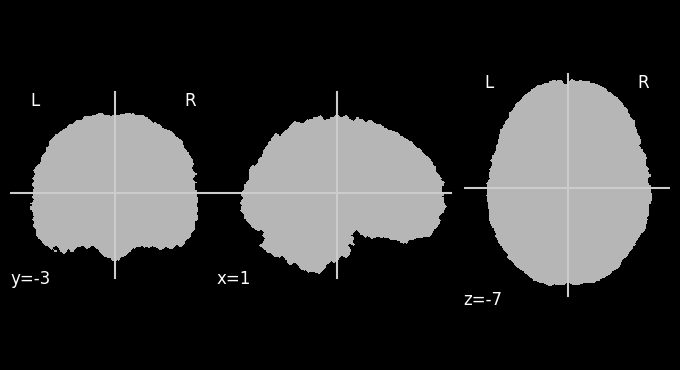

In [5]:
from nilearn.image import threshold_img
from nilearn.masking import compute_background_mask
from nilearn.plotting import plot_anat
from scipy.ndimage import binary_fill_holes


# get an approximate brain mask
mask = compute_background_mask(
    threshold_img(pet2.dynamic_mean(), threshold=0.5, two_sided=False),
    connected=True,
    opening=3,
)
mask_data = binary_fill_holes(mask.get_fdata())

mask = mask.__class__(mask_data.astype("float"), affine=mask.affine)
plot_anat(mask);

Next, we calculate the mean TAC in this brain mask:

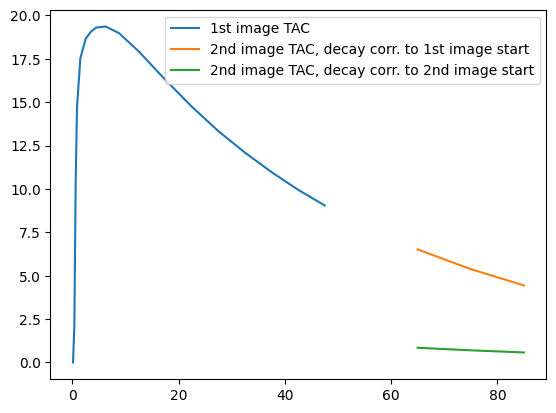

In [6]:
import matplotlib.pyplot as plt


pet1_tac = pet1.mean_timeseries_in_mask(mask=mask_data)
pet2_tac = pet2.mean_timeseries_in_mask(mask=mask_data)
pet2_tac_ = pet2_.mean_timeseries_in_mask(mask=mask_data)

plt.figure()
plt.plot(pet1_tac.frame_mid, pet1_tac.dataobj.flatten(), label="1st image TAC")
plt.plot(
    pet2_tac.frame_mid,
    pet2_tac.dataobj.flatten(),
    label="2nd image TAC, decay corr. to 1st image start",
)
plt.plot(
    pet2_tac_.frame_mid,
    pet2_tac_.dataobj.flatten(),
    label="2nd image TAC, decay corr. to 2nd image start",
)
plt.legend(loc="upper right");

This plot illustrates that in the real-life scenario, the reconstructed signal
in the second image (green curve) is lower than it should be. This is because
reconstruction corrects for only a small amount of decay time, meaning that the
acquired signal doesn't get at large of a boost at it would if decay correction
were done to the scan start of the first image.
We can fix this easily using functionality provided in _Dynamic PET_.

In practice, you would only have `pet1` and `pet2_`, not `pet2`.

Our goal is to concatenate these two scans, taking into account this difference
in decay correction.

_Dynamic PET_ makes this task easy via the `concatenate` function:

In [7]:
pet_concat = pet1.concatenate(pet2_)

We can verify that this works as intended by plotting the mean TAC in the brain
mask for the concatenated scan (shown using purple bars below):

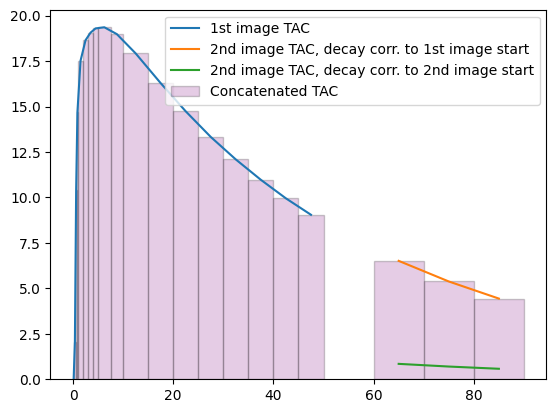

In [8]:
pet_concat_tac = pet_concat.mean_timeseries_in_mask(mask=mask_data)

plt.figure()
plt.plot(pet1_tac.frame_mid, pet1_tac.dataobj.flatten(), label="1st image TAC")
plt.plot(
    pet2_tac.frame_mid,
    pet2_tac.dataobj.flatten(),
    label="2nd image TAC, decay corr. to 1st image start",
)
plt.plot(
    pet2_tac_.frame_mid,
    pet2_tac_.dataobj.flatten(),
    label="2nd image TAC, decay corr. to 2nd image start",
)
plt.bar(
    pet_concat_tac.frame_start,
    pet_concat_tac.dataobj.flatten(),
    width=pet_concat_tac.frame_duration,
    edgecolor="black",
    color="purple",
    align="edge",
    alpha=0.2,
    label="Concatenated TAC",
)
plt.legend(loc="upper right");